In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample as ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_predict

In [2]:
# load the dataset from the course's repo
url = 'https://raw.githubusercontent.com/BI-DS/EBA-3530/main/Lecture_3/time_series.csv'
df = pd.read_csv(url, delimiter=',')
print('The size of the timeseries is {}'.format(df.shape[0]))

The size of the timeseries is 100


# Time series forecasting using AR models
Let's use a timeseries data set to do in-sample forecasting and out-of-sample forecasting. To that end, we use two different models:
\begin{align}
M1:& y_t = \beta_0 + \beta_1 y_{t-1} + ϵ_t \\
M2:& y_t = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2} + ϵ_t
\end{align}

Let's see how the timeseries looks like!

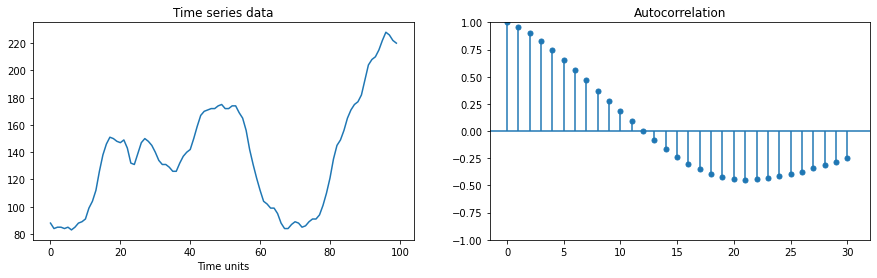

In [3]:
# plot the time series and the ACF
fig, axes = plt.subplots(1,2,figsize=(15,4))
axes[0].plot(df.y)
axes[0].set_title('Time series data')
axes[0].set(xlabel='Time units')
plot_acf(df.y,alpha=1,lags=30,ax=axes[1])
plt.show()

**Question:** What can you say about the data set? 

**Tips:** Think about the four components in timeseries data

## Differencing the timeseries

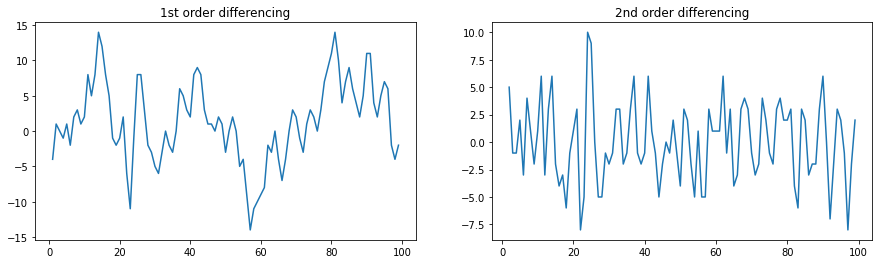

In [4]:
# use Pandas diff() function
# remember to drop NANs generated by differentation
diff_1 = df.y.diff().dropna()
diff_2 = df.y.diff().diff().dropna()

# plot again
fig, axes = plt.subplots(1,2,figsize=(15,4))
axes[0].plot(diff_1)
axes[0].set_title('1st order differencing')
axes[1].plot(diff_2)
axes[1].set_title('2nd order differencing')
plt.savefig('timeseries.pdf')
plt.show()

**Question:** Which series looks more mean-reverting?

 **Question:** Plot the ACF and PACF for both `diff_1` and `diff_2 `and compare them.

## Fitting AR models (In-sample)

In [7]:
# M1 model (AR(1))
# convert df to numpy using 'values'
ar1 = ARIMA(diff_2.values, order=(1,0,0)).fit()
print(ar1.summary())

# M2 now (AR(2))
ar2 = ARIMA(diff_2.values, order=(2,0,0)).fit()
print(ar2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   98
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -263.218
Date:                Mon, 13 Mar 2023   AIC                            532.437
Time:                        07:38:26   BIC                            540.192
Sample:                             0   HQIC                           535.574
                                 - 98                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0355      0.436      0.081      0.935      -0.819       0.890
ar.L1          0.1758      0.096      1.826      0.068      -0.013       0.365
sigma2        12.5990      1.869      6.740      0.0

**Question:** Calculate AIC and BIC using the formula that I showed in lecture 3.

**Tips:** Use the deviance formula from lecture 2, dropping the constat term.

### Plot in-sample fit

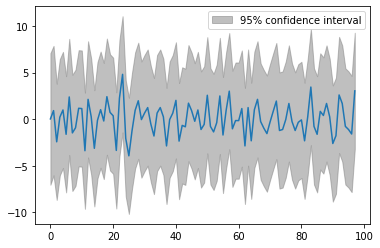

In [12]:
plot_predict(ar2)
plt.show()

**Question:** Comment the grey area

## Fitting AR models (Out-of-sample)

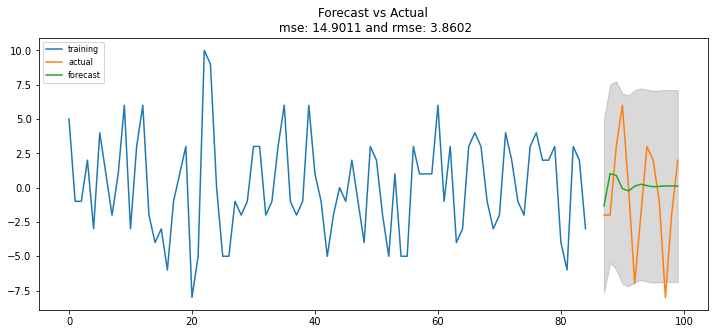

In [27]:
# 1-fold cross-validation
threshold = [85]
for th in threshold:
  y_tr = diff_2.values[:th]
  y_te = diff_2[th:]

  # fit the model
  ar2 = ARIMA(y_tr, order=(2, 0, 0)).fit() 
  # Forecast
  horizon = y_te.shape[0]
  results = ar2.get_forecast(horizon).summary_frame()
  fc, ci_lower, ci_upper = results['mean'], results['mean_ci_lower'], results['mean_ci_upper']

  # format results as df
  forecast = pd.Series(fc.values, index=y_te.index)
  lower_bound = pd.Series(ci_lower.values, index=y_te.index)
  upper_bound = pd.Series(ci_upper.values, index=y_te.index)

  # calculate your favorite metric, 
  # e.g. MSE as in slides or RMSE
  mse = np.mean((forecast - y_te)**2)
  rmse = np.mean((forecast - y_te)**2)**0.5

  # Plot
  plt.figure(figsize=(12,5))
  plt.plot(y_tr, label='training')
  plt.plot(y_te, label='actual')
  plt.plot(forecast, label='forecast')
  plt.fill_between(lower_bound.index, lower_bound, upper_bound, 
                 color='k', alpha=.15)
  plt.title('Forecast vs Actual\n mse: {0:.4f} and rmse: {1:.4f}'\
            .format(mse,rmse))
  plt.legend(loc='upper left', fontsize=8)
  plt.savefig('rmse_timeseries.pdf')
  plt.show()

**Question:** Add more values into `threshols = []` to run a K-folds cross validation with K=5 for example.

**Question:** Comment the difference between in-sample and out-of-sample fit (the two diagrams in the above blocks).